# Final Combined Model

**Description:** Polarity + Stress + Sarcasm + Baseline - Apply & Train on Twitter dataset

# 1. Mount Shared Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
max_length = 50

#### 1.1 Load Polarity Model

In [ ]:
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install pydot --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 1.1 MB/s 
     |████████████████████████████████| 4.9 MB 6.9 MB/s 
     |████████████████████████████████| 4.7 MB 8.2 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.5 MB/s 
     |████████████████████████████████| 596 kB 84.6 MB/s 


In [ ]:

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re
import gensim


from transformers import BertTokenizer, TFBertModel

import pandas as pd
import numpy as np

import transformers
# from transformers import BertTokenizer, TFBertModel
import tqdm
from keras.preprocessing import sequence
import tensorflow_text as tf_text

In [ ]:
## Load polarity model
def create_polarity_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_polarity')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_polarity')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_polarity')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)

    # Take average of classification token
    #avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_polarity')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_polarity')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    return classification_model

In [ ]:
polarity_model_path = '/content/drive/MyDrive/wzx/polarity_model/yelp_polarity_best_weights.h5'


polarity_model = create_polarity_model()
polarity_model.load_weights(polarity_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
polarity_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_polarity   [(None, 50)]        0           []                               
 (InputLayer)                                                                                     
                                                                                                  
 input_ids_layer_polarity (Inpu  [(None, 50)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer_polarity   [(None, 50)]        0           []                               
 (InputLayer)                                                                                 

In [ ]:
len(polarity_model.weights)

203

In [ ]:
polarity_model.layers[-2].output

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dropout_112')>

In [ ]:
concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, polarity_model.layers[-2].output], axis =0)

In [ ]:
concat_layer.shape

TensorShape([None, 100])

In [ ]:
type(concat_layer)

keras.layers.merge.Concatenate

#### 1.2 Load Sarcasm Model

In [ ]:
def create_sarcasm_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    ### YOUR CODE HERE

    #restrict training to the train_layers outer transformer layers

    model_checkpoint = 'bert-base-cased'
    bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
    bert_model = TFBertModel.from_pretrained(model_checkpoint)



    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_sarcasm') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_sarcasm')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_sarcasm')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_sarcasm')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_sarcasm')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy') 


    

    ### END YOUR CODE
    return classification_model

In [ ]:
sarcasm_model_path = '/content/drive/My Drive/wzx/sarcasm_model/sarcasm_best_weights.h5' #F"/content/gdrive/My Drive/wzx/{model_save_name}" 

sarcasm_model = create_sarcasm_model()
sarcasm_model.load_weights(sarcasm_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
sarcasm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_sarcasm (  [(None, 50)]        0           []                               
 InputLayer)                                                                                      
                                                                                                  
 input_ids_layer_sarcasm (Input  [(None, 50)]        0           []                               
 Layer)                                                                                           
                                                                                                  
 token_type_ids_layer_sarcasm (  [(None, 50)]        0           []                               
 InputLayer)                                                                                

#### 1.3 Load Stress Model

In [ ]:
# import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel
import tqdm
from keras.preprocessing import sequence
import tensorflow_text as tf_text

In [ ]:
#### Load Stress model
def create_stress_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):
    """
    Build a simple classification model with BERT
    """

    bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    # Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_stress') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_stress')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_stress')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    # Take average of classification token
    avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    # Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_stress')(avg_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    # concat_layer = tf.keras.layers.concatenate([layer1, layer2, layer3])
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_stress')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    ### END YOUR CODE
    
    return classification_model

In [ ]:
stress_model_path = '/content/drive/MyDrive/wzx/stress_model/stress_weights.h5'

stress_model = create_stress_model()
stress_model.load_weights(stress_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
stress_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                       
                                                                                                  
 input_ids_layer_stress (InputL  [(None, 50)]        0           []                               
 ayer)                                                                                            
                                                                                                  
 token_type_ids_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                 

### 1.4 Concatenate 3 models together

In [ ]:
concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, stress_model.layers[-2].output], axis=1)

In [ ]:
concat_layer.trainable = False

In [ ]:
concat_layer.shape

TensorShape([None, 200])

In [ ]:
#### Load Bert model
def create_ensemble_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):
    """
    Build a simple classification model with BERT
    """

    # bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
    # bert_model = TFBertModel.from_pretrained('bert-base-cased')
    # # Inputs
    # input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    # token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    # attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # bert_inputs = {'input_ids': input_ids,
    #                'token_type_ids': token_type_ids,
    #                'attention_mask': attention_mask}         

    # bert_out = bert_model(bert_inputs) 

    # Take average of classification token
    #avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    # Dense Hidden Layer
    #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(avg_token)
    #hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    

    concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, 
                                                sarcasm_model.layers[-2].output, 
                                                stress_model.layers[-2].output
                                                ], axis =1)
    #concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2](bert_out), stress_model.layers[-2](bert_out)], axis =1)
    #concat_layer= concat_layer(bert_out)


    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_ensemble')(concat_layer)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_ensemble')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[polarity_model.input, 
                                                  sarcasm_model.input, 
                                                  stress_model.input], 
                                          
                                          outputs=[classification])
    
    for layer in classification_model.layers[:-3]:
        layer.trainable=False
        for w in layer.weights: w._trainable=False

    # classification_model.layers[-4].trainable = False
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 
    



    ### END YOUR CODE
    
    return classification_model

In [ ]:
ensemble_model = create_ensemble_model()

In [ ]:
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                       
                                                                                                  
 input_ids_layer_stress (InputL  [(None, 50)]        0           []                               
 ayer)                                                                                            
                                                                                                  
 token_type_ids_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                 

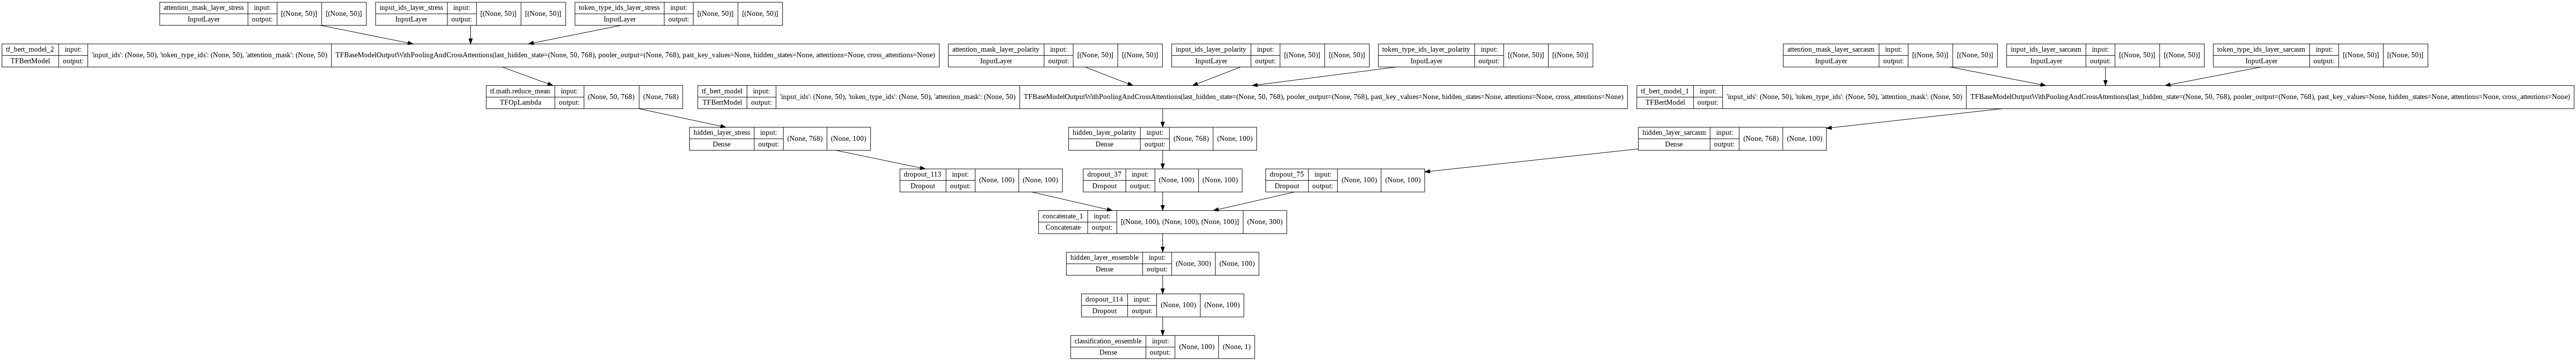

In [ ]:
keras.utils.plot_model(ensemble_model, "my_first_model_with_shape_info.png", show_shapes=True)

# Train Ensemble Model

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/wzx/data/train.csv')#.sample(n = 1000)
test = pd.read_csv('/content/drive/MyDrive/wzx/data/test.csv')#.sample(n = 1000)
valid = pd.read_csv('/content/drive/MyDrive/wzx/data/valid.csv')#.sample(n = 1000)

We have balanced dataset

In [ ]:
train['rating_label'].value_counts()

1    234161
0    233595
Name: rating_label, dtype: int64

In [ ]:
train.head()

,reviewText,rating_label
0,Hated,0
1,I understand people's frustration and i don't ...,0
2,Per the Editorial Review written by someone at...,0
3,It's very moving and brings back my memories f...,1
4,This movie didn't break new ground at all. Th...,0


Generate Input Data

In [ ]:
# def get_train_test(dataset, test_size=0.1):
#   # download & load 20newsgroups dataset from sklearn's repos
#   # dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
#   documents = dataset.comment
#   labels = dataset.label
#   # split into training & testing a return data as well as label names
#   return train_test_split(documents, labels, test_size=test_size, random_state = 42)
  
# # call the function
# train_texts, test_texts, train_labels, test_labels = get_train_test(data)

%%time

train_texts = list(train.reviewText.values)
train_labels = list(train.rating_label.values)

valid_texts = list(valid.reviewText.values)
valid_labels = list(valid.rating_label.values)

test_texts = list(test.reviewText.values)
test_labels = list(test.rating_label.values)


max_length = 50

# Polarity Model Input

polarity_model_checkpoint = 'bert-base-cased'
polarity_tokenizer = BertTokenizer.from_pretrained(polarity_model_checkpoint)

train_encodings_polarity = polarity_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_polarity = polarity_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_polarity = polarity_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Sarcasm Model Input


sarcasm_model_checkpoint = 'bert-base-cased'
sarcasm_tokenizer = BertTokenizer.from_pretrained(sarcasm_model_checkpoint)

train_encodings_sarcasm = sarcasm_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_sarcasm = sarcasm_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_sarcasm = sarcasm_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Stress Model Input

stress_model_checkpoint = 'bert-large-uncased'
stress_tokenizer = BertTokenizer.from_pretrained(stress_model_checkpoint)

train_encodings_stress = stress_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_stress = stress_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_stress = stress_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')




CPU times: user 1h 14min 24s, sys: 22 s, total: 1h 14min 46s
Wall time: 1h 14min 34s


In [ ]:
train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)
test_labels = np.asarray(test_labels)

In [ ]:
ensemble_model.input

[[<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_polarity')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_polarity')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_polarity')>],
 [<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_sarcasm')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_sarcasm')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_sarcasm')>],
 [<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_stress')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_stress')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_stress')>]]

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/ensemble_best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_model = create_ensemble_model()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]


ensemble_model_history = ensemble_model.fit([polarity_train_input, sarcasm_train_input, stress_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input], 
                                                  valid_labels),
                             
                                                  batch_size=128, 
                                                  epochs=10,
                                                  callbacks=[model_checkpoint_callback]
                                                  ) 




Epoch 1/10
3655/3655 [==============================] - 1899s 515ms/step - loss: 0.4711 - accuracy: 0.8014 - val_loss: 0.4146 - val_accuracy: 0.8240
Epoch 2/10
3655/3655 [==============================] - 1878s 514ms/step - loss: 0.4308 - accuracy: 0.8165 - val_loss: 0.4127 - val_accuracy: 0.8246
Epoch 3/10
3655/3655 [==============================] - 1884s 516ms/step - loss: 0.4265 - accuracy: 0.8173 - val_loss: 0.4122 - val_accuracy: 0.8253
Epoch 4/10
3655/3655 [==============================] - 1882s 515ms/step - loss: 0.4239 - accuracy: 0.8178 - val_loss: 0.4101 - val_accuracy: 0.8257
Epoch 5/10
3655/3655 [==============================] - 1878s 514ms/step - loss: 0.4221 - accuracy: 0.8180 - val_loss: 0.4073 - val_accuracy: 0.8260
Epoch 6/10
3655/3655 [==============================] - 1876s 513ms/step - loss: 0.4211 - accuracy: 0.8178 - val_loss: 0.4041 - val_accuracy: 0.8270
Epoch 7/10
3655/3655 [==============================] - 1864s 510ms/step - loss: 0.4201 - accuracy: 0.8181

In [ ]:
print('Complete Training')

Complete Training


In [ ]:
score = ensemble_model.evaluate([polarity_test_input, sarcasm_test_input, stress_test_input], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', np.round(score[1], 5))

4568/4568 [==============================] - 539s 118ms/step - loss: 0.4002 - accuracy: 0.8269
Test loss: 0.40017348527908325
Test accuracy: 0.82687


# Ensemble V2

In [ ]:
## Load baseline model
def create_baseline_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')


    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_baseline')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_baseline')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_baseline')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)

    # Take average of classification token
    #avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_baseline')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_baseline')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    return classification_model

In [ ]:
baseline_model_path = '/content/drive/MyDrive/wzx/baseline/baseline_best_weights.h5'

baseline_model = create_baseline_model()
baseline_model.load_weights(baseline_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:

def create_ensemble_v2(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):
    """
    Build a simple classification model with BERT
    """


    concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, 
                                                sarcasm_model.layers[-2].output, 
                                                stress_model.layers[-2].output,
                                                baseline_model.layers[-2].output
                                                ], axis =1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_ensemble_v2')(concat_layer)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_ensemble_v2')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[polarity_model.input, 
                                                  sarcasm_model.input, 
                                                  stress_model.input,
                                                  baseline_model.input
                                                  ], 
                                          
                                          outputs=[classification])
    
    # Freeze the sentiment layers except the ensemble layer
    for layer in classification_model.layers[:-3]:
        layer.trainable=False
        for w in layer.weights: w._trainable=False

    # for layer in classification_model.layers:
    #     layer._name += '_v2'


    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 
    



    ### END YOUR CODE
    
    return classification_model

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/ensemble_v2_best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_v2 = create_ensemble_v2()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]
baseline_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]
baseline_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]
baseline_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]


ensemble_v2_history = ensemble_v2.fit([polarity_train_input, sarcasm_train_input, stress_train_input, baseline_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input, baseline_valid_input], 
                                                  valid_labels),
                          
                                                  batch_size=128, 
                                                  epochs=10,
                                                  callbacks=[model_checkpoint_callback]
                                                  ) 

Epoch 1/10
3655/3655 [==============================] - 2534s 672ms/step - loss: 0.0789 - accuracy: 0.9755 - val_loss: 0.2360 - val_accuracy: 0.9351
Epoch 2/10
3655/3655 [==============================] - 2453s 671ms/step - loss: 0.0614 - accuracy: 0.9803 - val_loss: 0.2109 - val_accuracy: 0.9351
Epoch 3/10
3655/3655 [==============================] - 2458s 673ms/step - loss: 0.0598 - accuracy: 0.9806 - val_loss: 0.2047 - val_accuracy: 0.9352
Epoch 4/10
 676/3655 [====>.........................] - ETA: 27:02 - loss: 0.0576 - accuracy: 0.9813

KeyboardInterrupt: ignored

In [ ]:
print('Complete Training')

In [ ]:
ensemble_v2_path = '/content/drive/My Drive/wzx/ensemble_v2_best_weights.h5'
ensemble_v2 = create_ensemble_v2()
ensemble_v2.load_weights(ensemble_v2_path)


In [ ]:
score = ensemble_v2.evaluate([polarity_test_input, sarcasm_test_input, stress_test_input, baseline_test_input], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', np.round(score[1], 5))

4568/4568 [==============================] - 719s 153ms/step - loss: 0.2039 - accuracy: 0.9353
Test loss: 0.2038818895816803
Test accuracy: 0.93534


# Additonal test on unseen twitter data

In [ ]:
 twitter_data = pd.read_csv('/content/drive/MyDrive/wzx/data/twitter_processed.csv')#.sample(n = 100)
twitter_data.head()

,rating_label,reviewText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:

%%time

twitter_texts = list(twitter_data.reviewText.values)
twitter_labels = list(twitter_data.rating_label.values)


max_length = 50

# Polarity Model Input

polarity_model_checkpoint = 'bert-base-cased'
polarity_tokenizer = BertTokenizer.from_pretrained(polarity_model_checkpoint)
twitter_encodings_polarity = polarity_tokenizer(twitter_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Sarcasm Model Input
twitter_encodings_sarcasm = twitter_encodings_polarity

# Stress Model Input

stress_model_checkpoint = 'bert-large-uncased'
stress_tokenizer = BertTokenizer.from_pretrained(stress_model_checkpoint)
twitter_encodings_stress = stress_tokenizer(twitter_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Baseline Model Input
twitter_encodings_baseline = twitter_encodings_polarity



CPU times: user 20min 49s, sys: 0 ns, total: 20min 49s
Wall time: 21min 4s


In [ ]:
polarity_twitter_input = [twitter_encodings_polarity.input_ids, twitter_encodings_polarity.token_type_ids, twitter_encodings_polarity.attention_mask]
sarcasm_twitter_input = [twitter_encodings_sarcasm.input_ids, twitter_encodings_sarcasm.token_type_ids, twitter_encodings_sarcasm.attention_mask]
stress_twitter_input = [twitter_encodings_stress.input_ids, twitter_encodings_stress.token_type_ids, twitter_encodings_stress.attention_mask]
baseline_twitter_input = [twitter_encodings_baseline.input_ids, twitter_encodings_baseline.token_type_ids, twitter_encodings_baseline.attention_mask]

In [ ]:
twitter_labels = np.asarray(twitter_labels)

In [ ]:
ensemble_score = ensemble_v2.evaluate([polarity_twitter_input, sarcasm_twitter_input, stress_twitter_input, baseline_twitter_input], 
                                                  twitter_labels) 

print('Ensemble V2')
print('Test loss:', ensemble_score[0]) 
print('Test accuracy:', np.round(ensemble_score[1], 5))

50000/50000 [==============================] - 6712s 134ms/step - loss: 1.2152 - accuracy: 0.6458
Ensemble V2
Test loss: 1.215177059173584
Test accuracy: 0.64581


In [ ]:
baseline_model_path = '/content/drive/MyDrive/wzx/baseline/baseline_best_weights.h5'

baseline_model = create_baseline_model()
baseline_model.load_weights(baseline_model_path)


baseline_score = baseline_model.evaluate(baseline_twitter_input, 
                                         
                                          twitter_labels) 


print('Baseline')
print('Test loss:', baseline_score[0]) 
print('Test accuracy:', np.round(baseline_score[1], 5))

# Train & Test on Twitter Polarity Data

In [ ]:
twitter_data = pd.read_csv('/content/drive/MyDrive/wzx/data/twitter_processed.csv')#.sample(n = 100)
twitter_data.head()

,rating_label,reviewText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_data['rating_label'].value_counts()

0    800000
1    800000
Name: rating_label, dtype: int64

In [ ]:
# We have a balanced dataset with 800,000 vs. 800,000
from sklearn.model_selection import train_test_split

xxx, xtest, yyy, ytest = train_test_split(twitter_data['reviewText'],twitter_data['rating_label'],test_size = 0.2,random_state = 32)
xtrain,xvalid,ytrain,yvalid = train_test_split(xxx,yyy,test_size = 0.2,random_state = 21)

# Training & Test Data
twitter_train = pd.concat([xtrain,ytrain],axis = 1).reset_index(drop=True)
twitter_valid = pd.concat([xvalid,yvalid],axis = 1).reset_index(drop=True)
twitter_test = pd.concat([xtest,ytest],axis=1).reset_index(drop=True)

In [ ]:
twitter_train['rating_label'].value_counts()

1    512537
0    511463
Name: rating_label, dtype: int64

In [ ]:
twitter_valid['rating_label'].value_counts()

0    128216
1    127784
Name: rating_label, dtype: int64

In [ ]:
twitter_test['rating_label'].value_counts()

0    160321
1    159679
Name: rating_label, dtype: int64

In [ ]:
train_texts = list(twitter_train.reviewText.values)
train_labels = list(twitter_train.rating_label.values)

In [ ]:
%%time

train_texts = list(twitter_train.reviewText.values)
train_labels = list(twitter_train.rating_label.values)

valid_texts = list(twitter_valid.reviewText.values)
valid_labels = list(twitter_valid.rating_label.values)

test_texts = list(twitter_test.reviewText.values)
test_labels = list(twitter_test.rating_label.values)


max_length = 50

# Polarity Model Input

polarity_model_checkpoint = 'bert-base-cased'
polarity_tokenizer = BertTokenizer.from_pretrained(polarity_model_checkpoint)

train_encodings_polarity = polarity_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_polarity = polarity_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_polarity = polarity_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Sarcasm Model Input


sarcasm_model_checkpoint = 'bert-base-cased'
sarcasm_tokenizer = BertTokenizer.from_pretrained(sarcasm_model_checkpoint)

train_encodings_sarcasm = sarcasm_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_sarcasm = sarcasm_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_sarcasm = sarcasm_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Stress Model Input

stress_model_checkpoint = 'bert-large-uncased'
stress_tokenizer = BertTokenizer.from_pretrained(stress_model_checkpoint)

train_encodings_stress = stress_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_stress = stress_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_stress = stress_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

CPU times: user 28min 30s, sys: 10.2 s, total: 28min 40s
Wall time: 28min 39s


In [ ]:
train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)
test_labels = np.asarray(test_labels)

In [ ]:
ensemble_model.input

[[<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_polarity')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_polarity')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_polarity')>],
 [<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_sarcasm')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_sarcasm')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_sarcasm')>],
 [<KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'input_ids_layer_stress')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'token_type_ids_layer_stress')>,
  <KerasTensor: shape=(None, 50) dtype=int64 (created by layer 'attention_mask_layer_stress')>]]

# Train Twitter Ensemble Model

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/twitter_ensemble_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_model = create_ensemble_model()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]


ensemble_model_history = ensemble_model.fit([polarity_train_input, sarcasm_train_input, stress_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input], 
                                                  valid_labels),
                             
                                                  batch_size=128, 
                                                  epochs=3,
                                                  callbacks=[model_checkpoint_callback]
                                                  )


Epoch 1/3
8000/8000 [==============================] - 13328s 2s/step - loss: 0.6153 - accuracy: 0.6755 - val_loss: 0.5923 - val_accuracy: 0.6898
Epoch 2/3
8000/8000 [==============================] - 13335s 2s/step - loss: 0.5955 - accuracy: 0.6873 - val_loss: 0.5904 - val_accuracy: 0.6909
Epoch 3/3
  35/8000 [..............................] - ETA: 2:59:43 - loss: 0.5890 - accuracy: 0.6920

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/twitter_ensemble_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_model = create_ensemble_model()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]


ensemble_model_history = ensemble_model.fit([polarity_train_input, sarcasm_train_input, stress_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input], 
                                                  valid_labels),
                             
                                                  batch_size=128, 
                                                  steps_per_epoch=10,
                                                  epochs=10,
                                                  callbacks=[model_checkpoint_callback]
                                                  )



Epoch 1/10
10/10 [==============================] - 1366s 151s/step - loss: 0.9157 - accuracy: 0.4875 - val_loss: 0.7725 - val_accuracy: 0.3789
Epoch 2/10
10/10 [==============================] - 1341s 149s/step - loss: 0.8662 - accuracy: 0.5031 - val_loss: 0.7240 - val_accuracy: 0.4550
Epoch 3/10
10/10 [==============================] - 1342s 149s/step - loss: 0.8318 - accuracy: 0.5117 - val_loss: 0.6832 - val_accuracy: 0.5746
Epoch 4/10
10/10 [==============================] - 1345s 149s/step - loss: 0.8205 - accuracy: 0.5188 - val_loss: 0.6540 - val_accuracy: 0.6349
Epoch 5/10
10/10 [==============================] - 1341s 149s/step - loss: 0.7869 - accuracy: 0.5570 - val_loss: 0.6361 - val_accuracy: 0.6726
Epoch 6/10
10/10 [==============================] - 1341s 149s/step - loss: 0.8031 - accuracy: 0.5477 - val_loss: 0.6251 - val_accuracy: 0.6822
Epoch 7/10
10/10 [==============================] - 1343s 149s/step - loss: 0.8019 - accuracy: 0.5383 - val_loss: 0.6178 - val_accuracy:

In [ ]:
print('Complete Training')

Complete Training


# Twitter Ensemble + Baseline (V2)

In [ ]:
## Load baseline model
def create_baseline_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')


    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_baseline')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_baseline')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_baseline')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)

    # Take average of classification token
    #avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_baseline')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_baseline')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    return classification_model

In [ ]:
baseline_model_path = '/content/drive/MyDrive/wzx/baseline/twitter_best_weights.h5'

baseline_model = create_baseline_model()
baseline_model.load_weights(baseline_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def create_ensemble_v2(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):
    """
    Build a simple classification model with BERT
    """


    concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, 
                                                sarcasm_model.layers[-2].output, 
                                                stress_model.layers[-2].output,
                                                baseline_model.layers[-2].output
                                                ], axis =1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_ensemble_v2')(concat_layer)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_ensemble_v2')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[polarity_model.input, 
                                                  sarcasm_model.input, 
                                                  stress_model.input,
                                                  baseline_model.input
                                                  ], 
                                          
                                          outputs=[classification])
    
    # Freeze the sentiment layers except the ensemble layer
    for layer in classification_model.layers[:-3]:
        layer.trainable=False
        for w in layer.weights: w._trainable=False

    # for layer in classification_model.layers:
    #     layer._name += '_v2'


    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 
    



    ### END YOUR CODE
    
    return classification_model

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/twitter_ensemble_v2_best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_v2 = create_ensemble_v2()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]
baseline_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]
baseline_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]
baseline_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]


ensemble_v2_history = ensemble_v2.fit([polarity_train_input, sarcasm_train_input, stress_train_input, baseline_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input, baseline_valid_input], 
                                                  valid_labels),
                                                  steps_per_epoch=1000,
                                                  batch_size=128, 
                                                  epochs=10,
                                                  callbacks=[model_checkpoint_callback]
                                                  ) 

Epoch 1/10
1000/1000 [==============================] - 2738s 3s/step - loss: 0.3465 - accuracy: 0.8580 - val_loss: 0.3534 - val_accuracy: 0.8608
Epoch 2/10
1000/1000 [==============================] - 2695s 3s/step - loss: 0.2733 - accuracy: 0.8937 - val_loss: 0.3386 - val_accuracy: 0.8606
Epoch 3/10
1000/1000 [==============================] - 2695s 3s/step - loss: 0.2673 - accuracy: 0.8935 - val_loss: 0.3344 - val_accuracy: 0.8607
Epoch 4/10
1000/1000 [==============================] - 2695s 3s/step - loss: 0.2631 - accuracy: 0.8943 - val_loss: 0.3311 - val_accuracy: 0.8607
Epoch 5/10
1000/1000 [==============================] - 2694s 3s/step - loss: 0.2615 - accuracy: 0.8949 - val_loss: 0.3318 - val_accuracy: 0.8605
Epoch 6/10
1000/1000 [==============================] - 2693s 3s/step - loss: 0.2620 - accuracy: 0.8947 - val_loss: 0.3295 - val_accuracy: 0.8606
Epoch 7/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.8960

In [ ]:
print('Complete Training')

Complete Training


In [ ]:
ensemble_v2_path = '/content/drive/My Drive/wzx/twitter_ensemble_v2_best_weights.h5'
ensemble_v2 = create_ensemble_v2()
ensemble_v2.load_weights(ensemble_v2_path)

In [ ]:
polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]
baseline_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]
baseline_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]
baseline_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]


In [ ]:
score = ensemble_v2.evaluate([polarity_test_input, sarcasm_test_input, stress_test_input, baseline_test_input], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', np.round(score[1], 5))

10000/10000 [==============================] - 2479s 247ms/step - loss: 0.3507 - accuracy: 0.8612
Test loss: 0.35074764490127563
Test accuracy: 0.86122
